## Unzip Dataset

In [1]:
!unzip 'train.zip'
!unzip 'val.zip'
!unzip 'test.zip'

Archive:  train.zip
   creating: train/
   creating: train/NORMAL/
  inflating: train/NORMAL/IM-0115-0001.jpeg  
  inflating: train/NORMAL/IM-0117-0001.jpeg  
  inflating: train/NORMAL/IM-0119-0001.jpeg  
  inflating: train/NORMAL/IM-0122-0001.jpeg  
  inflating: train/NORMAL/IM-0125-0001.jpeg  
  inflating: train/NORMAL/IM-0127-0001.jpeg  
  inflating: train/NORMAL/IM-0128-0001.jpeg  
  inflating: train/NORMAL/IM-0129-0001.jpeg  
  inflating: train/NORMAL/IM-0131-0001.jpeg  
  inflating: train/NORMAL/IM-0133-0001.jpeg  
  inflating: train/NORMAL/IM-0135-0001.jpeg  
  inflating: train/NORMAL/IM-0137-0001.jpeg  
  inflating: train/NORMAL/IM-0140-0001.jpeg  
  inflating: train/NORMAL/IM-0141-0001.jpeg  
  inflating: train/NORMAL/IM-0143-0001.jpeg  
  inflating: train/NORMAL/IM-0145-0001.jpeg  
  inflating: train/NORMAL/IM-0147-0001.jpeg  
  inflating: train/NORMAL/IM-0149-0001.jpeg  
  inflating: train/NORMAL/IM-0151-0001.jpeg  
  inflating: train/NORMAL/IM-0152-0001.jpeg  
  inflating: 

In [1]:
training_path = "train"
test_path = "test"
val_path = "val"

## Understanding the Data

Populating the interactive namespace from numpy and matplotlib


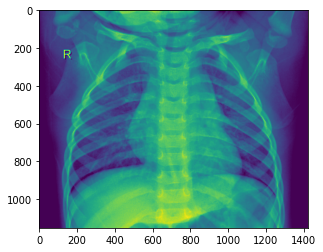

In [2]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('train/NORMAL/IM-0117-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

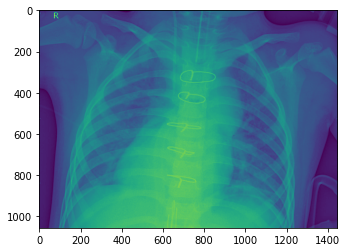

In [3]:
img = mpimg.imread('train/PNEUMONIA/person2_bacteria_3.jpeg')
imgplot = plt.imshow(img)
plt.show()

## Import Libraries & Load Images

In [68]:
import tensorflow
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout,  Activation, GlobalMaxPooling2D
from tensorflow.keras import optimizers
from keras import layers
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.models import Model, Sequential
from keras.preprocessing import image
import matplotlib.pyplot as plt
import tensorflow.keras.backend as k
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#### Normalizing & Scaling Data

In [48]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, shear_range=0.2, zoom_range=0.2, fill_mode='nearest')  #Divide pixels by 255(where pixel value range from 0-255) and scale them between 0-1
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

#### Loading Images

In [49]:
train_generator = train_datagen.flow_from_directory(training_path, target_size =(150,150), class_mode='binary', classes=['NORMAL','PNEUMONIA'])
val_generator = test_datagen.flow_from_directory(val_path, target_size =(150,150), class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_path, target_size =(150,150), class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [7]:
train_class = train_generator.classes
test_class = test_generator.classes
val_class = val_generator.classes

In [8]:
from collections import Counter

train_counter = Counter(train_class)
val_counter = Counter(val_class)
test_counter = Counter(test_class)
print("Training: {}".format(train_counter))
print("Validation: {}".format(val_counter))
print("Testing: {}".format(test_counter))

Training: Counter({1: 3875, 0: 1341})
Validation: Counter({0: 8, 1: 8})
Testing: Counter({1: 390, 0: 234})


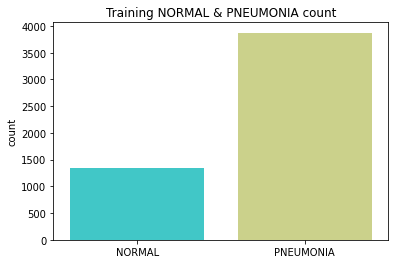

In [9]:
sns.countplot(x=train_class, palette="rainbow")
plt.title("Training NORMAL & PNEUMONIA count")
plt.xticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.show()

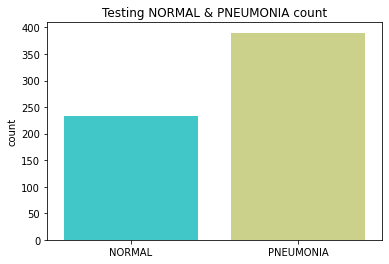

In [10]:
sns.countplot(x=test_class, palette="rainbow")
plt.title("Testing NORMAL & PNEUMONIA count")
plt.xticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.show()

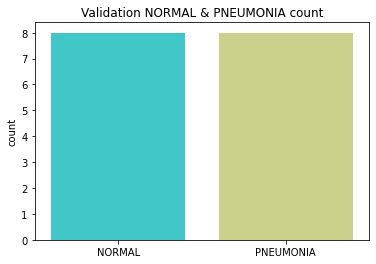

In [11]:
sns.countplot(x=val_class, palette="rainbow")
plt.title("Validation NORMAL & PNEUMONIA count")
plt.xticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.show()

#### Setting weights for managing Imbalanced Data which will be used while traing the data

In [50]:
#https://medium.com/@judopro/how-i-got-best-score-on-kaggle-detecting-chest-pneumonia-with-xray-images-using-deep-learning-546c874a7d49
import pandas as pd
import math

df = pd.DataFrame({'data': train_class})
no_pne = int(df[df.data == train_generator.class_indices['NORMAL']].count())
yes_pne = int(df[df.data == train_generator.class_indices['PNEUMONIA']].count())

imb_rat = round(yes_pne / no_pne, 2)

no_weight = imb_rat
yes_weight = 1.0

cweights = {
    train_generator.class_indices['NORMAL']:no_weight,
    train_generator.class_indices['PNEUMONIA']:yes_weight
}

text = "Normal:{:.0f}\nPneumonia:{:.0f}\nImbalance Ratio: {:.2f}\n".format(no_pne, yes_pne, imb_rat)
print(text)
text = "Using class_weights as:\nNormal:{:.2f}\nPneumonia:{:.2f}\n".format(no_weight, yes_weight)
print(text)

Normal:1341
Pneumonia:3875
Imbalance Ratio: 2.89

Using class_weights as:
Normal:2.89
Pneumonia:1.00



In [13]:
img_width, img_height = 150, 150

#### Checking whether color channels come first

In [14]:
if k.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
input_shape

(150, 150, 3)

## Model Building

#### Convolutional Neural Network (CNN)

In [15]:
model = Sequential()
#Feature Extraction
#Block 1
model.add(Conv2D(32,(3,3),input_shape=input_shape)) 
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
#Block 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
#Block 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Classification
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) # 2 because we have normal and pneumonia classes

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 72, 72, 64)       2

In [16]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(train_generator, epochs=15, batch_size=64, class_weight=cweights, validation_data=test_generator, verbose=1)

Epoch 1/15
163/163 [==============================] - 64s 372ms/step - loss: 0.5078 - accuracy: 0.8382 - val_loss: 4.2542 - val_accuracy: 0.6250
Epoch 2/15
163/163 [==============================] - 55s 334ms/step - loss: 0.3541 - accuracy: 0.8951 - val_loss: 7.8075 - val_accuracy: 0.6234
Epoch 3/15
163/163 [==============================] - 54s 334ms/step - loss: 0.3013 - accuracy: 0.9172 - val_loss: 2.5786 - val_accuracy: 0.6619
Epoch 4/15
163/163 [==============================] - 54s 333ms/step - loss: 0.2738 - accuracy: 0.9289 - val_loss: 3.9809 - val_accuracy: 0.6250
Epoch 5/15
163/163 [==============================] - 54s 334ms/step - loss: 0.2704 - accuracy: 0.9247 - val_loss: 0.8449 - val_accuracy: 0.8654
Epoch 6/15
163/163 [==============================] - 54s 333ms/step - loss: 0.2383 - accuracy: 0.9400 - val_loss: 2.7401 - val_accuracy: 0.6266
Epoch 7/15
163/163 [==============================] - 54s 332ms/step - loss: 0.2080 - accuracy: 0.9425 - val_loss: 2.6773 - val_ac

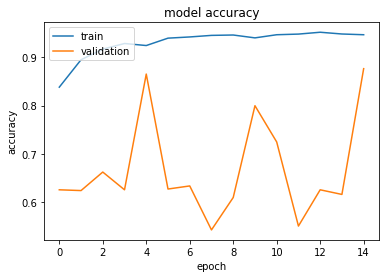

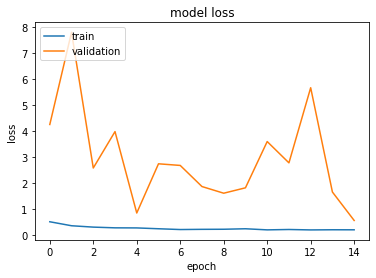

In [18]:
# "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### VGG16

In [52]:
num_of_classes = 2
batch_size = 32

base_model = VGG16(weights='imagenet', input_shape=input_shape, include_top=False)
    
for layer in base_model.layers:
    if layer.name != 'block5_conv3':
        layer.trainable = False
    else:
        layer.trainable = True

x = base_model.output
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(x) #Pooling + Flatten
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model1 = Model(inputs=base_model.input, outputs=x)
model1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [53]:
optSGD = optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model1.compile(loss='binary_crossentropy', optimizer=optSGD, metrics=['accuracy'])

In [55]:
hist_vgg = model1.fit_generator(generator=train_generator,
                    validation_data=test_generator,
                    class_weight=cweights,
                    epochs=50, verbose=1)

Epoch 1/50
163/163 [==============================] - 55s 332ms/step - loss: 0.7338 - accuracy: 0.7636 - val_loss: 0.4280 - val_accuracy: 0.8237
Epoch 2/50
163/163 [==============================] - 54s 331ms/step - loss: 0.4902 - accuracy: 0.8671 - val_loss: 0.3594 - val_accuracy: 0.8462
Epoch 3/50
163/163 [==============================] - 54s 331ms/step - loss: 0.3955 - accuracy: 0.8861 - val_loss: 0.3233 - val_accuracy: 0.8590
Epoch 4/50
163/163 [==============================] - 54s 331ms/step - loss: 0.3621 - accuracy: 0.8997 - val_loss: 0.3046 - val_accuracy: 0.8718
Epoch 5/50
163/163 [==============================] - 54s 331ms/step - loss: 0.3339 - accuracy: 0.9028 - val_loss: 0.2892 - val_accuracy: 0.8766
Epoch 6/50
163/163 [==============================] - 54s 332ms/step - loss: 0.3091 - accuracy: 0.9126 - val_loss: 0.2790 - val_accuracy: 0.8910
Epoch 7/50
163/163 [==============================] - 54s 331ms/step - loss: 0.2864 - accuracy: 0.9260 - val_loss: 0.2744 - val_ac

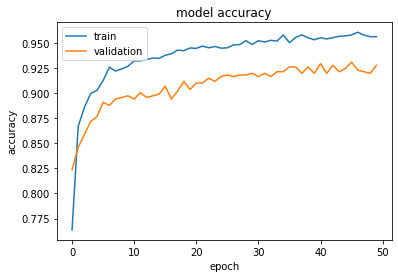

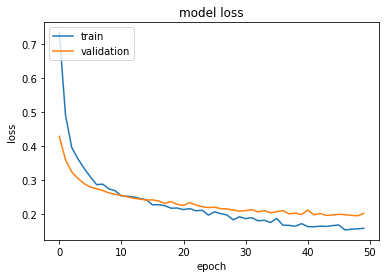

In [56]:
# "Accuracy"
plt.plot(hist_vgg.history['accuracy'])
plt.plot(hist_vgg.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist_vgg.history['loss'])
plt.plot(hist_vgg.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### RESNET50

In [62]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in resnet_model.layers:
    layer.trainable = False
    
x = Flatten()(resnet_model.output)
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
model2 = Model(inputs=resnet_model.input, outputs=x)
model2.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_10[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

In [63]:
model2.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adamax(learning_rate=0.001),
                  metrics=['accuracy'])

hist_rest = model2.fit_generator(
    train_generator, 
    validation_data = test_generator,
    class_weight=cweights,
    workers=10,
    epochs=50,
)

Epoch 1/50
163/163 [==============================] - 35s 189ms/step - loss: 0.9021 - accuracy: 0.6562 - val_loss: 0.5081 - val_accuracy: 0.7644
Epoch 2/50
163/163 [==============================] - 31s 183ms/step - loss: 0.6468 - accuracy: 0.7966 - val_loss: 0.3931 - val_accuracy: 0.8253
Epoch 3/50
163/163 [==============================] - 31s 182ms/step - loss: 0.5111 - accuracy: 0.8493 - val_loss: 0.3916 - val_accuracy: 0.8253
Epoch 4/50
163/163 [==============================] - 31s 184ms/step - loss: 0.4670 - accuracy: 0.8606 - val_loss: 0.3497 - val_accuracy: 0.8462
Epoch 5/50
163/163 [==============================] - 31s 185ms/step - loss: 0.4269 - accuracy: 0.8746 - val_loss: 0.3322 - val_accuracy: 0.8654
Epoch 6/50
163/163 [==============================] - 31s 181ms/step - loss: 0.3987 - accuracy: 0.8844 - val_loss: 0.3386 - val_accuracy: 0.8638
Epoch 7/50
163/163 [==============================] - 31s 182ms/step - loss: 0.4439 - accuracy: 0.8689 - val_loss: 0.3260 - val_ac

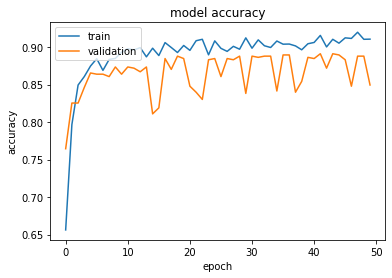

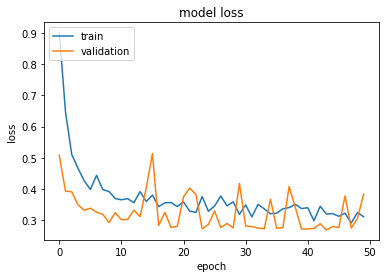

In [64]:
# "Accuracy"
plt.plot(hist_rest.history['accuracy'])
plt.plot(hist_rest.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist_rest.history['loss'])
plt.plot(hist_rest.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### InceptionV3

In [69]:
base_model = InceptionV3(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
output = Dense(1, activation='sigmoid')(x)

model3 = Model(inputs=base_model.input, outputs=output)
model3.summary()

87924736/87910968 [==============================] - 2s 0us/step
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 74, 74, 32)   864         ['input_11[0][0]']               
                                                                                                  
 batch_normalization_10 (BatchN  (None, 74, 74, 32)  96          ['conv2d_3[0][0]']               
 ormalization)                                                                                    
                           

In [71]:
opt = optimizers.Adam(learning_rate=0.0003)
model3.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

hist_incep = model3.fit_generator(
    train_generator, 
    validation_data = test_generator,
    class_weight=cweights,
    workers=10,
    epochs=50,
)

Epoch 1/50
163/163 [==============================] - 36s 190ms/step - loss: 0.4448 - accuracy: 0.8591 - val_loss: 0.4242 - val_accuracy: 0.8397
Epoch 2/50
163/163 [==============================] - 31s 181ms/step - loss: 0.3134 - accuracy: 0.9089 - val_loss: 0.3808 - val_accuracy: 0.8333
Epoch 3/50
163/163 [==============================] - 31s 181ms/step - loss: 0.2809 - accuracy: 0.9222 - val_loss: 0.2669 - val_accuracy: 0.8958
Epoch 4/50
163/163 [==============================] - 31s 183ms/step - loss: 0.2700 - accuracy: 0.9289 - val_loss: 0.3020 - val_accuracy: 0.8814
Epoch 5/50
163/163 [==============================] - 31s 179ms/step - loss: 0.2648 - accuracy: 0.9325 - val_loss: 0.2692 - val_accuracy: 0.9022
Epoch 6/50
163/163 [==============================] - 31s 181ms/step - loss: 0.2595 - accuracy: 0.9317 - val_loss: 0.2632 - val_accuracy: 0.9103
Epoch 7/50
163/163 [==============================] - 31s 182ms/step - loss: 0.2461 - accuracy: 0.9390 - val_loss: 0.2528 - val_ac

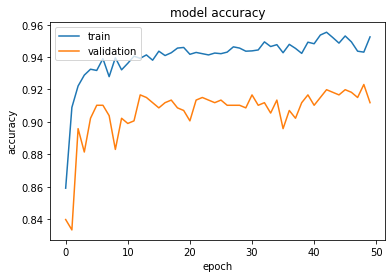

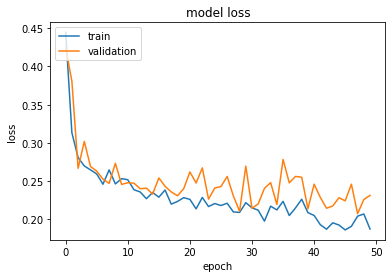

In [72]:
# "Accuracy"
plt.plot(hist_incep.history['accuracy'])
plt.plot(hist_incep.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist_incep.history['loss'])
plt.plot(hist_incep.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()